<a href="https://colab.research.google.com/github/chongzicbo/Dive-into-Deep-Learning-tf.keras/blob/master/7.4.%20%E5%8A%A8%E9%87%8F%E6%B3%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##7.4. 动量法
在“梯度下降和随机梯度下降”一节中我们提到，目标函数有关自变量的梯度代表了目标函数在自变量当前位置下降最快的方向。因此，梯度下降也叫作最陡下降（steepest descent）。在每次迭代中，梯度下降根据自变量当前位置，沿着当前位置的梯度更新自变量。然而，如果自变量的迭代方向仅仅取决于自变量当前位置，这可能会带来一些问题。

###7.4.1. 梯度下降的问题
让我们考虑一个输入和输出分别为二维向量$\boldsymbol{x} = [x_1, x_2]^\top$ 和标量的目标函数$f(\boldsymbol{x})=0.1x_1^2+2x_2^2$。与“梯度下降和随机梯度下降”一节中不同，这里将$x_1^2$系数从 1 减小到了 0.1 。下面实现基于这个目标函数的梯度下降，并演示使用学习率为 0.4 时自变量的迭代轨迹。

In [0]:
%matplotlib inline
import math
import tensorflow as tf
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import losses
from tensorflow.data import Dataset
import time

In [0]:
tf.enable_eager_execution()

In [0]:
eta=0.4
def f_2d(x1,x2):
  return 0.1*x1**2+2*x2**2

def gd_2d(x1,x2,s1,s2):
  return (x1-eta*0.2*x1,x2-eta*4*x2,0,0)

epoch 20,x1 -0.943467,x2 -0.000073


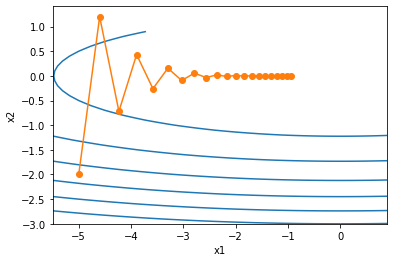

In [0]:
def show_trace_2d(f,results):
  plt.plot(*zip(*results),'-o',color='#ff7f0e')
  x1,x2=np.meshgrid(np.arange(-5.5,1.0,0.1),np.arange(-3.0,1.0,0.1))
  plt.contour(x1,x2,f(x1,x2),colors='#1f77b4')
  plt.xlabel('x1')
  plt.ylabel('x2')
def train_2d(trainer):
  x1,x2,s1,s2=-5,-2,0,0 #s1,s2是自变量状态,本章后续几节会使用
  results=[(x1,x2)]
  for i in range(20):
    x1,x2,s1,s2=trainer(x1,x2,s1,s2)
    results.append((x1,x2))
  print('epoch %d,x1 %f,x2 %f'%(i+1,x1,x2))
  return results

show_trace_2d(f_2d,train_2d(gd_2d))

可以看到，同一位置上，目标函数在竖直方向（ $x_2$ 轴方向）比在水平方向（ $x_1$ 轴方向）的斜率的绝对值更大。因此，给定学习率，梯度下降迭代自变量时会使自变量在竖直方向比在水平方向移动幅度更大。那么，我们需要一个较小的学习率从而避免自变量在竖直方向上越过目标函数最优解。然而，这会造成自变量在水平方向上朝最优解移动变慢。

下面我们试着将学习率调得稍大一点，此时自变量在竖直方向不断越过最优解并逐渐发散。

epoch 20,x1 -0.387814,x2 -1673.365109


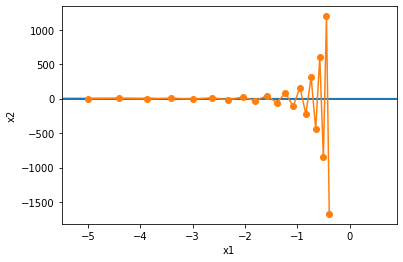

In [0]:
eta=0.6
show_trace_2d(f_2d,train_2d(gd_2d))

###7.4.2. 动量法
动量法的提出是为了解决梯度下降的上述问题。由于小批量随机梯度下降比梯度下降更为广义，本章后续讨论将沿用“小批量随机梯度下降”一节中时间步 $t $的小批量随机梯度 $\boldsymbol{g}_t$的定义。设时间步 $t$ 的自变量为 $x_t$ ，学习率为$\eta_t$。 在时间步 0 ，动量法创建速度变量 $v_0$ ，并将其元素初始化成0。在时间步 $t>0$ ，动量法对每次迭代的步骤做如下修改：
$$
\begin{split}\begin{aligned}
\boldsymbol{v}_t &\leftarrow \gamma \boldsymbol{v}_{t-1} + \eta_t \boldsymbol{g}_t, \\
\boldsymbol{x}_t &\leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{v}_t,
\end{aligned}\end{split}
$$
其中，动量超参数 $\gamma$满足$0 \leq \gamma < 1$。当 $\gamma=0$时，动量法等价于小批量随机梯度下降。

在解释动量法的数学原理前，让我们先从实验中观察梯度下降在使用动量法后的迭代轨迹。

In [0]:
def momentum_2d(x1,x2,v1,v2):
  v1=gamma*v1+eta*0.2*x1
  v2=gamma*v2+eta*4*x2
  return x1-v1,x2-v2,v1,v2

epoch 20,x1 -0.062843,x2 0.001202


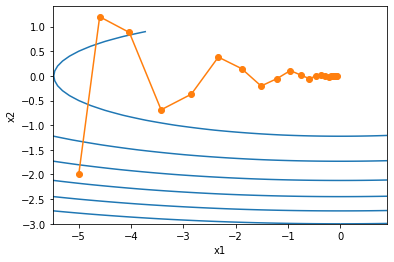

In [0]:
eta,gamma=0.4,0.5
show_trace_2d(f_2d,train_2d(momentum_2d))

可以看到使用较小的学习率 $\eta=0.4$ 和动量超参数 $\gamma=0.5$ 时，动量法在竖直方向上的移动更加平滑，且在水平方向上更快逼近最优解。下面使用较大的学习率 $\eta=0.6$ ，此时自变量也不再发散。

epoch 20,x1 0.007188,x2 0.002553


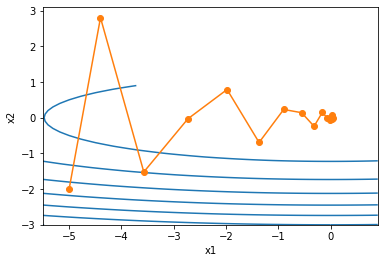

In [0]:
eta=0.6
show_trace_2d(f_2d,train_2d(momentum_2d))

####7.4.2.1. 指数加权移动平均
为了从数学上理解动量法，让我们先解释一下指数加权移动平均（exponentially weighted moving average）。给定超参数$0 \leq \gamma < 1$，当前时间步 $t$ 的变量 $y_t$ 是上一时间步 $t-1$ 的变量 $y_{t-1} $和当前时间步另一变量 $x_t $的线性组合：
$$
y_t = \gamma y_{t-1} + (1-\gamma) x_t.
$$
我们可以对 $y_t$ 展开：
$$
\begin{split}\begin{aligned}
y_t  &= (1-\gamma) x_t + \gamma y_{t-1}\\
         &= (1-\gamma)x_t + (1-\gamma) \cdot \gamma x_{t-1} + \gamma^2y_{t-2}\\
         &= (1-\gamma)x_t + (1-\gamma) \cdot \gamma x_{t-1} + (1-\gamma) \cdot \gamma^2x_{t-2} + \gamma^3y_{t-3}\\
         &\ldots
\end{aligned}\end{split}
$$
令$n = 1/(1-\gamma)$，那么$\left(1-1/n\right)^n = \gamma^{1/(1-\gamma)}$。因为$$\lim_{n \rightarrow \infty}  \left(1-\frac{1}{n}\right)^n = \exp(-1) \approx 0.3679,$$

所以当$\gamma \rightarrow 1$时，$\gamma^{1/(1-\gamma)}=\exp(-1)$，如$0.95^{20} \approx \exp(-1)$。如果把 exp(−1) 当作一个比较小的数，我们可以在近似中忽略所有含$\gamma^{1/(1-\gamma)}$和比$\gamma^{1/(1-\gamma)}$更高阶的系数的项。例如，当 $\gamma=0.95$时，
$$
y_t \approx 0.05 \sum_{i=0}^{19} 0.95^i x_{t-i}.
$$
因此，在实际中，我们常常将 $y_t $看作是对最近 $1/(1-\gamma)$个时间步的 $x_t$ 值的加权平均。例如，当$\gamma = 0.95$时， $y_t$ 可以被看作对最近20个时间步的 $x_t$ 值的加权平均；当$\gamma = 0.9$时， $y_t$ 可以看作是对最近10个时间步的 $x_t$ 值的加权平均。而且，离当前时间步 $t$ 越近的 $x_t$ 值获得的权重越大（越接近1）。

####7.4.2.2. 由指数加权移动平均理解动量法
现在，我们对动量法的速度变量做变形：
$$
\boldsymbol{v}_t \leftarrow \gamma \boldsymbol{v}_{t-1} + (1 - \gamma) \left(\frac{\eta_t}{1 - \gamma} \boldsymbol{g}_t\right).
$$
由指数加权移动平均的形式可得，速度变量 $v_t$ 实际上对序列$\{\eta_{t-i}\boldsymbol{g}_{t-i} /(1-\gamma):i=0,\ldots,1/(1-\gamma)-1\}$做了指数加权移动平均。换句话说，相比于小批量随机梯度下降，动量法在每个时间步的自变量更新量近似于将前者对应的最近 $1/(1-\gamma)$个时间步的更新量做了指数加权移动平均后再除以 $1-\gamma$
。所以，在动量法中，自变量在各个方向上的移动幅度不仅取决当前梯度，还取决于过去的各个梯度在各个方向上是否一致。在本节之前示例的优化问题中，所有梯度在水平方向上为正（向右），而在竖直方向上时正（向上）时负（向下）。这样，我们就可以使用较大的学习率，从而使自变量向最优解更快移动。

###7.4.3. 从零开始实现
相对于小批量随机梯度下降，动量法需要对每一个自变量维护一个同它一样形状的速度变量，且超参数里多了动量超参数。实现中，我们将速度变量用更广义的状态变量states表示。

In [0]:
from google.colab import drive
drive.mount('/content/drive')

def get_data_ch7():
  data=np.genfromtxt('/content/drive/My Drive/data/d2l-zh-tensoflow/airfoil_self_noise.dat',delimiter='\t')
  data=(data-data.mean(axis=0))/data.std(axis=0)
  return tf.constant(data[:1500,:-1]),tf.constant(data[:1500,-1])

features,labels=get_data_ch7()  

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def init_momentum_states():
  v_w=tf.Variable(tf.zeros(shape=(features.shape[1],1),dtype=tf.double))
  v_b=tf.Variable(tf.zeros(1,dtype=tf.double))
  return (v_w,v_b)

def sgd_momentum(params,states,hyperparams,loss,t):
  for p,v in zip(params,states):
    dl_dp=t.gradient(loss,p)
    v.assign(hyperparams['momentum']*v+hyperparams['lr']*dl_dp)
    p.assign_sub(v)

In [0]:
def train_ch7(trainer_fn,states,hyperparams,features,labels,batch_size=10,num_epochs=2):
  net,loss=linreg,squared_loss
  w=tf.Variable(tf.random.normal(stddev=0.01,shape=(features.shape[1],1),dtype=tf.double))
  b=tf.Variable(tf.zeros(1,dtype=tf.double))

  def eval_loss():
    return tf.reduce_mean(loss(net(features,w,b),labels)).numpy()

  ls=[eval_loss()]

  data_iter=Dataset.from_tensor_slices((features,labels)).shuffle(buffer_size=1000).batch(batch_size)

  for _ in range(num_epochs):
    start=time.time()
    for batch_i,(X,y) in enumerate(data_iter):
      with tf.GradientTape(persistent=True) as t:
        t.watch([w,b])
        l=tf.reduce_mean(loss(net(X,w,b),y)) #使用平均损失

      trainer_fn([w,b],states,hyperparams,l,t) #迭代模型参数

      if(batch_i+1)*batch_size %100==0:
        ls.append(eval_loss()) #每100个样本记录下当前训练误差
  # 打印结果和作图
  print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
  set_figsize()
  plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
  plt.xlabel('epoch')
  plt.ylabel('loss')  

def use_svg_display():
  #用矢量图显示
  display.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5,2.5)):
  use_svg_display()
  #设置图的尺寸
  plt.rcParams['figure.figsize']=figsize
  
  
def linreg(X,w,b):
  return tf.matmul(X,w)+b 
  
def squared_loss(y_hat,y):
  return (y_hat-tf.reshape(y,shape=y_hat.shape))**2/2    

我们先将动量超参数momentum设0.5，这时可以看成是特殊的小批量随机梯度下降：其小批量随机梯度为最近2个时间步的2倍小批量梯度的加权平均。

loss: 0.248673, 0.431266 sec per epoch


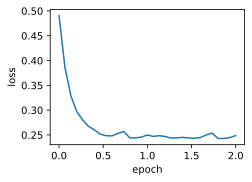

In [0]:
train_ch7(sgd_momentum,init_momentum_states(),{'lr':0.02,'momentum':0.5},features,labels)

将动量超参数momentum增大到0.9，这时依然可以看成是特殊的小批量随机梯度下降：其小批量随机梯度为最近10个时间步的10倍小批量梯度的加权平均。我们先保持学习率0.02不变。

loss: 0.272450, 0.440948 sec per epoch


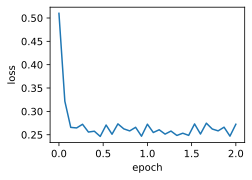

In [0]:
train_ch7(sgd_momentum,init_momentum_states(),{'lr':0.02,'momentum':0.9},features,labels)

可见目标函数值在后期迭代过程中的变化不够平滑。直觉上，10倍小批量梯度比2倍小批量梯度大了5倍，我们可以试着将学习率减小到原来的1/5。此时目标函数值在下降了一段时间后变化更加平滑。

loss: 0.242490, 0.432922 sec per epoch


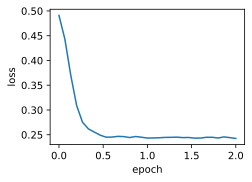

In [0]:
train_ch7(sgd_momentum,init_momentum_states(),{'lr':0.004,'momentum':0.9},features,labels)

###7.4.4. 简洁实现

In [0]:
def train_keras_ch7(trainer_name,features,labels,batch_size=10,num_epochs=2):
  net=keras.Sequential(keras.layers.Dense(1))
  loss=losses.mean_squared_error
  data_iter=Dataset.from_tensor_slices((features,labels)).shuffle(buffer_size=1000).batch(batch_size)
  net.compile(optimizer=trainer_name,loss=loss)
  history=net.fit_generator(data_iter,epochs=num_epochs)
  loss_ls=history.history['loss']
  set_figsize()
  plt.plot(np.linspace(0,num_epochs,len(loss_ls)),loss_ls)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.show()
  return history

Epoch 1/10
150/150 [==============================] - 1s 5ms/step - loss: 0.5574
Epoch 2/10
150/150 [==============================] - 1s 5ms/step - loss: 0.4977
Epoch 3/10
150/150 [==============================] - 1s 5ms/step - loss: 0.4981
Epoch 4/10
150/150 [==============================] - 1s 5ms/step - loss: 0.4981
Epoch 5/10
150/150 [==============================] - 1s 5ms/step - loss: 0.4981
Epoch 6/10
150/150 [==============================] - 1s 5ms/step - loss: 0.4981
Epoch 7/10
150/150 [==============================] - 1s 5ms/step - loss: 0.4981
Epoch 8/10
150/150 [==============================] - 1s 5ms/step - loss: 0.4981
Epoch 9/10
150/150 [==============================] - 1s 5ms/step - loss: 0.4981
Epoch 10/10
150/150 [==============================] - 1s 5ms/step - loss: 0.4981


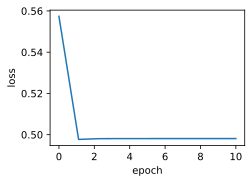

In [0]:
train_keras_ch7(keras.optimizers.SGD(learning_rate=0.004,momentum=0.9),features,labels,batch_size=10,num_epochs=10)